### Run ACTION_RECOGNITION.ipynb before running model_analysis.ipynb #####

In [61]:
import numpy as np
from sklearn import metrics
import os
import pickle
import matplotlib.pyplot as plt
import collections
from movingpose.estimator import classifiers
from movingpose.estimator import neighbors

### Tuning parameters

In [62]:
# Strength of precision vs recall
f1_beta = 1
f1_average = "weighted"

### Load model data and generate metrics

In [63]:
cur_uuid = "c7f7094d" # str(input("cur_uuid:"))
dir_path = f"../pickle/{cur_uuid}"

if not (cur_uuid != "" and os.path.isdir(dir_path)):
    print("ERROR :: UUID not found")
    print("Please enter the correct UUID or run action_recognition.ipynb and pass in the associated UUID")
    exit(1)

print("Loading data...")

with open(dir_path + "/train_test_splits.p", 'rb') as fp:
    training_data = pickle.load(fp)

X_train, X_test = training_data["X_train"], training_data["X_test"]
y_train, y_test = training_data["y_train"], training_data["y_test"]

all_predictions_fns = [file_name for file_name in os.listdir(dir_path) if file_name.startswith("prediction")]

# results_dict[str(action_classifier)] = {
#   "y_pred": y_pred,
#   "action_classifier_params": action_classifier_params,
#   "confusion_matrix": confusion_matrix,
#   "precision": precision,
#   "recall": recall,
#   "fbetascore": fscore,
#   "support": support,
#   "accuracy": accuracy,
#   "prediction_speed": prediction_speed
# }
predictions_dict = {}

for prediction_fn in all_predictions_fns:
    with open(f"{dir_path}/{prediction_fn}", 'rb') as fp:
        prediction_info = pickle.load(fp)

        action_classifier_name = prediction_info["action_classifier_name"]
        jank_y_pred = prediction_info["y_pred"]
        action_classifier_params = prediction_info["action_classifier_params"]
        prediction_speed = prediction_info["prediction_speed"]

        y_pred = []
        for pred in jank_y_pred:
            if isinstance(pred, tuple):
                y_pred.append(pred[0])
            else:
                y_pred.append(pred)
        y_pred = np.array(y_pred)

        confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
        precision, recall, fscore, support = metrics.precision_recall_fscore_support(
            y_test, y_pred, beta=f1_beta, average=f1_average
        )
        accuracy = metrics.accuracy_score(y_test, y_pred)

        predictions_dict[action_classifier_name] = {
            "y_pred": y_pred,
            "action_classifier_params": action_classifier_params,
            "confusion_matrix": confusion_matrix,
            "precision": precision,
            "recall": recall,
            "fbetascore": fscore,
            "support": support,
            "accuracy": accuracy,
            "prediction_speed": prediction_speed
        }

Loading data...


/home/mobley/Documents/repos/CSCI470-Final/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Organize hyper parameter combinations

In [64]:
# hpc_values[hpc_name] = set(hpc_value, ... (all hpc_values))
hpc_values_dict = collections.defaultdict(set)

for model_name, prediction_info in predictions_dict.items():
    action_classifier = prediction_info["action_classifier_params"]
    pose_estimator = action_classifier["nearest_pose_estimator"]

    hpcs = {
        "theta": action_classifier["theta"],
        "n": action_classifier["n"],
        "alpha": pose_estimator["alpha"],
        "beta": pose_estimator["beta"],
        "kappa": pose_estimator["kappa"],
        "n_neighbors": pose_estimator["n_neighbors"],
        "n_training_neighbors": pose_estimator["n_training_neighbors"]
    }

    for hpc_name, hpc_value in hpcs.items():
        hpc_values_dict[hpc_name].add(hpc_value)

# hpc_combinations[hpc_name] = set("str(action_recognition) with wildcard for hpc_value", ... (all hpc name templates))
hpc_combinations = collections.defaultdict(set)
for hpc_name in hpc_values_dict.keys():
    for theta in hpc_values_dict["theta"]:
        for n in hpc_values_dict["n"]:
            for alpha in hpc_values_dict["alpha"]:
                for beta in hpc_values_dict["beta"]:
                    for kappa in hpc_values_dict["kappa"]:
                        for n_neighbors in hpc_values_dict["n_neighbors"]:
                            for n_training_neighbors in hpc_values_dict["n_training_neighbors"]:
                                nearest_pose_estimator = neighbors.NearestPoses(
                                    n_neighbors=n_neighbors,
                                    n_training_neighbors=n_training_neighbors,
                                    alpha=alpha,
                                    beta=beta,
                                    kappa=kappa
                                )
                                action_classifier = classifiers.ActionClassifier(
                                    nearest_pose_estimator=nearest_pose_estimator,
                                    theta=theta,
                                    n=n
                                )
                                model_name = str(action_classifier)
                                model_name_parts = model_name.split("=")
                                for i, model_name_part in enumerate(model_name_parts):
                                    if not model_name_part.endswith(hpc_name):
                                        continue
                                    first_underscore = model_name_parts[i+1].find('_')
                                    model_name_parts[i+1] = "%s" + model_name_parts[i+1][first_underscore:]
                                    break
                                template_name = "=".join(model_name_parts)
                                hpc_combinations[hpc_name].add(template_name)

#### Assert all required prediction files exist

In [65]:
failed = False
for hpc_name, model_name_templates in hpc_combinations.items():
        for hpc_value in hpc_values_dict[hpc_name]:
            for model_name_template in model_name_templates:
                if not os.path.isfile(f"{dir_path}/prediction-[{model_name_template % str(hpc_value)}].p"):
                    print(model_name_template % hpc_value)
                    failed = True
assert not failed

#### Visualize hyperparameter combinations

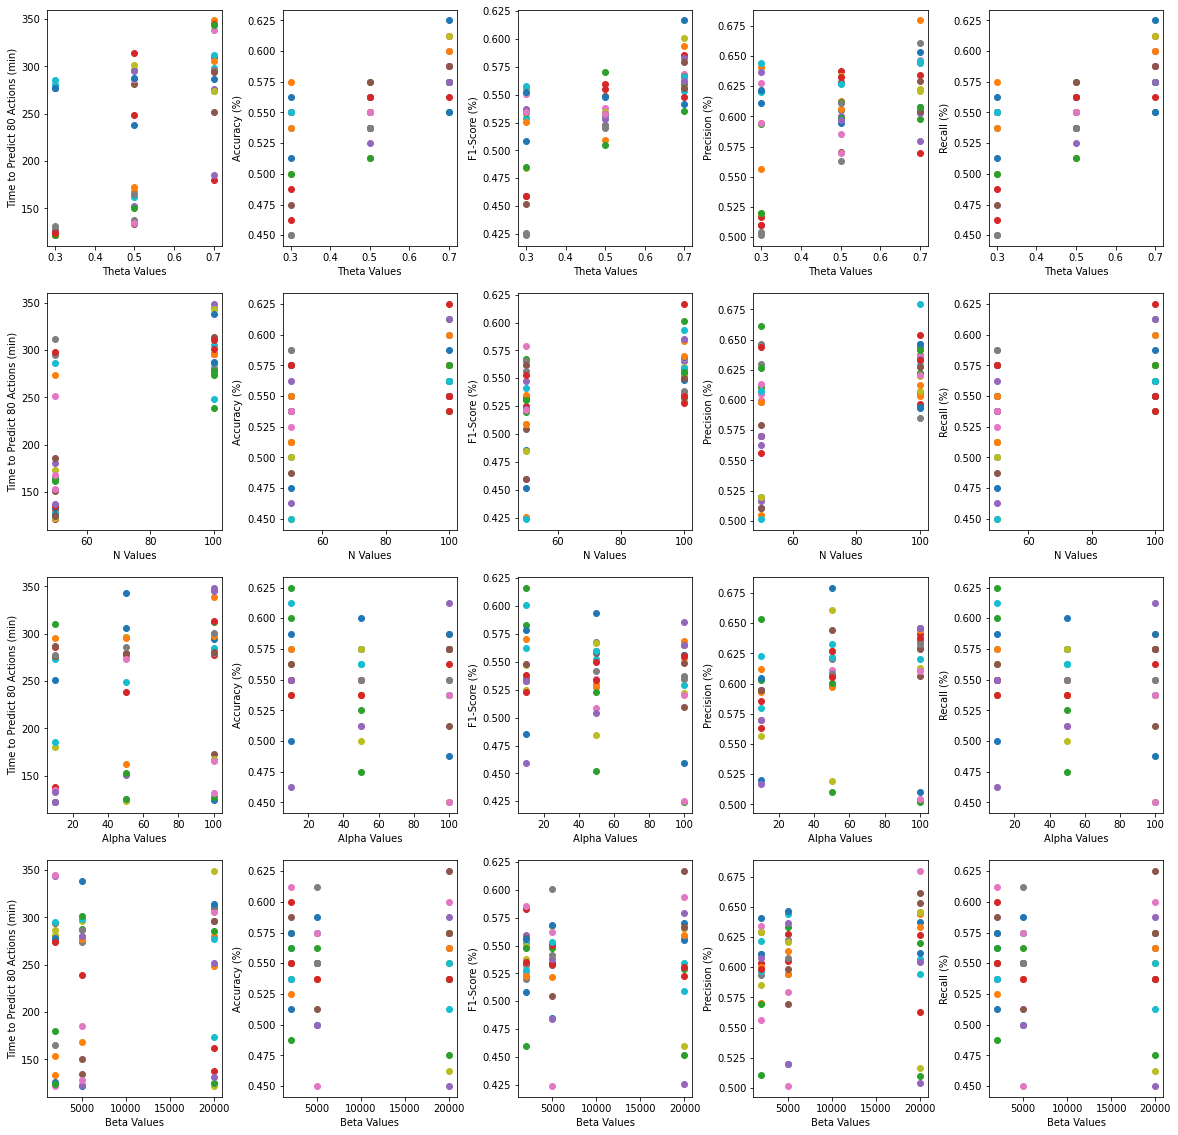

In [66]:
metrics = [
    {
        "id": "prediction_speed",
        "name": "Time to Predict 80 Actions (min)"
    },
    {
        "id": "accuracy",
        "name": "Accuracy (%)"
    },
    {
        "id": "fbetascore",
        "name": f"F{f1_beta}-Score (%)"
    },
    {
        "id": "precision",
        "name": "Precision (%)"
    },
    {
        "id": "recall",
        "name": "Recall (%)"
    }
]
hpc_names = list(hpc_values_dict.copy().keys())

subtract_amount = 0

plots = collections.defaultdict(list)
for hpc_name, model_name_templates in hpc_combinations.items():
    values = hpc_values_dict[hpc_name]
    if len(values) == 1:
        subtract_amount += 1
        continue
    for hpc_value in hpc_values_dict[hpc_name]:
        for model_name_template in model_name_templates:
            prediction_info = predictions_dict[model_name_template % hpc_value]
            for metric_num, metric_info in enumerate(metrics):
                plots[(hpc_names.index(hpc_name) - subtract_amount, metric_num)].append(
                    (hpc_value, prediction_info[metric_info["id"]])
                )

fig, axs = plt.subplots(len(hpc_values_dict.values()) - subtract_amount, 5, figsize=(20,20))
for (col, row), plot in plots.items():
    for (x, y) in plot:
        axs[col, row].scatter(x, y)
    xlabel = f"{hpc_names[col].title()} Values"
    ylabel = metrics[row]["name"]
    axs[col, row].set(xlabel=xlabel, ylabel=ylabel)

plt.subplots_adjust(wspace=0.35)
plt.show()